<a href="https://colab.research.google.com/github/ThierrryScotto/cais_maua/blob/main/cais_maua_interpolated_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Getting the data

In [2]:
# url = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/CausMauaSemTratamento.csv" # sem tratamentos
url = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/datasetInterpolate.csv"
# url = "./datasetInterpolate2.csv"

dataset = pd.read_csv(url, names=['date_time', 'mm/h', 'level_cm', 'temperature'])
dataset

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227,23.1
1,2014-07-29 13:45:00,0.0,227,23.1
2,2014-07-29 14:00:00,0.0,227,23.1
3,2014-07-29 14:15:00,0.0,225,23.1
4,2014-07-29 14:30:00,0.0,223,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260,19.0
346503,2024-06-15 23:15:00,0.0,261,19.0
346504,2024-06-15 23:30:00,0.2,261,19.0
346505,2024-06-15 23:45:00,0.0,262,19.0


# Data Preparation

help functions

In [3]:
FIGSIZE = (20, 20)

In [4]:
def plot_dataset(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [5]:
def plot_dataset_scatter(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.scatter(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [6]:
dataset

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227,23.1
1,2014-07-29 13:45:00,0.0,227,23.1
2,2014-07-29 14:00:00,0.0,227,23.1
3,2014-07-29 14:15:00,0.0,225,23.1
4,2014-07-29 14:30:00,0.0,223,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260,19.0
346503,2024-06-15 23:15:00,0.0,261,19.0
346504,2024-06-15 23:30:00,0.2,261,19.0
346505,2024-06-15 23:45:00,0.0,262,19.0


In [7]:
dataset.columns

Index(['date_time', 'mm/h', 'level_cm', 'temperature'], dtype='object')

In [8]:
dataset.isnull().sum()

date_time      0
mm/h           0
level_cm       0
temperature    0
dtype: int64

In [9]:
dataset.describe()

,mm/h,level_cm,temperature
count,346507.000000,346507.000000,346507.000000
mean,0.069696,167.413221,22.163576
std,1.256536,55.444910,5.638025
min,0.000000,63.000000,4.900000
25%,0.000000,133.000000,18.100000
50%,0.000000,157.000000,22.100000
75%,0.000000,186.000000,25.900000
max,680.600000,535.000000,41.800000


In [10]:
dataset['date_time'] = pd.to_datetime(dataset['date_time'])
dataset.set_index('date_time', inplace=True)

dataset

,mm/h,level_cm,temperature
date_time,,,
2014-07-29 13:30:00,0.0,227,23.1
2014-07-29 13:45:00,0.0,227,23.1
2014-07-29 14:00:00,0.0,227,23.1
2014-07-29 14:15:00,0.0,225,23.1
2014-07-29 14:30:00,0.0,223,24.1
...,...,...,...
2024-06-15 23:00:00,0.0,260,19.0
2024-06-15 23:15:00,0.0,261,19.0
2024-06-15 23:30:00,0.2,261,19.0


In [11]:
dataset.dtypes

mm/h           float64
level_cm         int64
temperature    float64
dtype: object

# Time series analysis

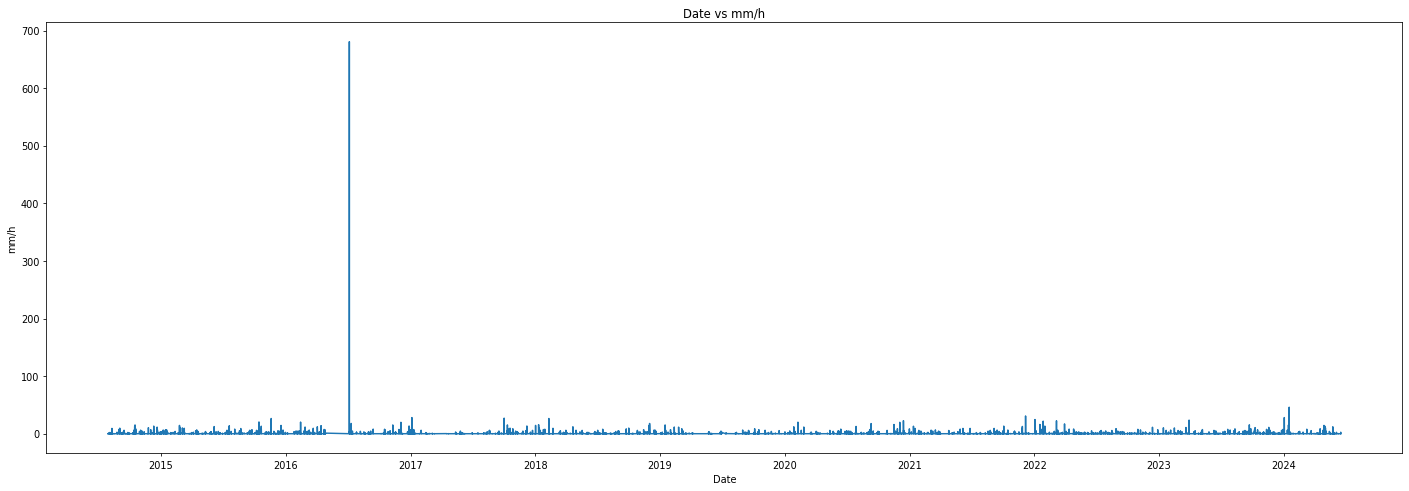

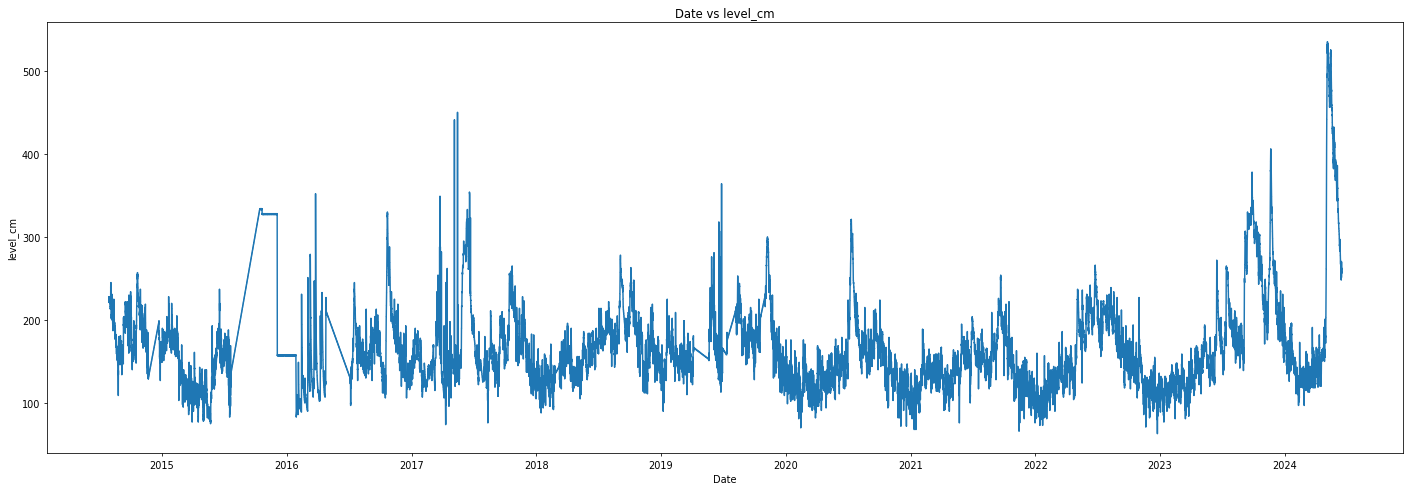

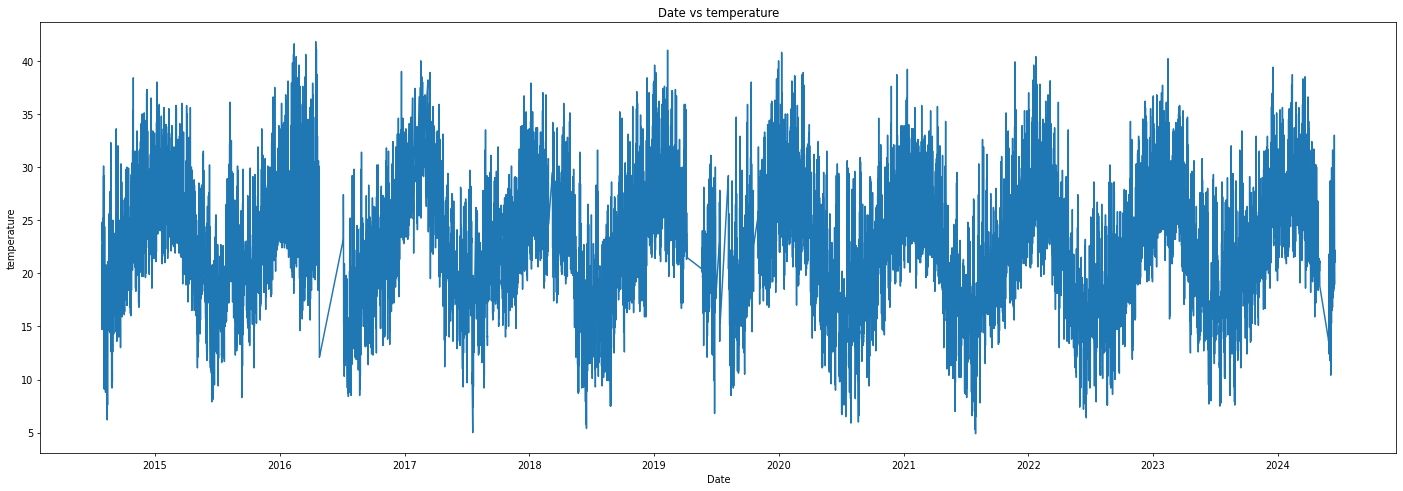

In [12]:
for feature in dataset.columns:
    plot_dataset(dataset.index, dataset[f'{feature}'], 'Date', f'{feature}', f'Date vs {feature}', figsize=(25, 8), dpi=70)

### **Selecting time**

In [13]:
# Definir a faixa de datas
start_date = '2020-08-01'

# Selecionar os dados dentro da faixa de datas
df_filtered = dataset[start_date:]

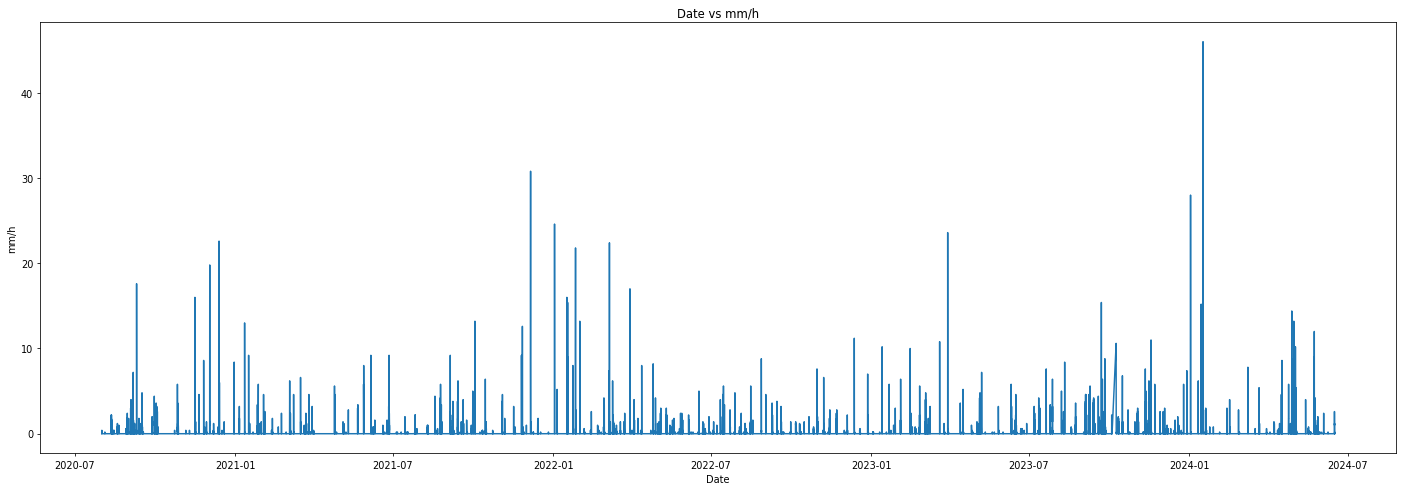

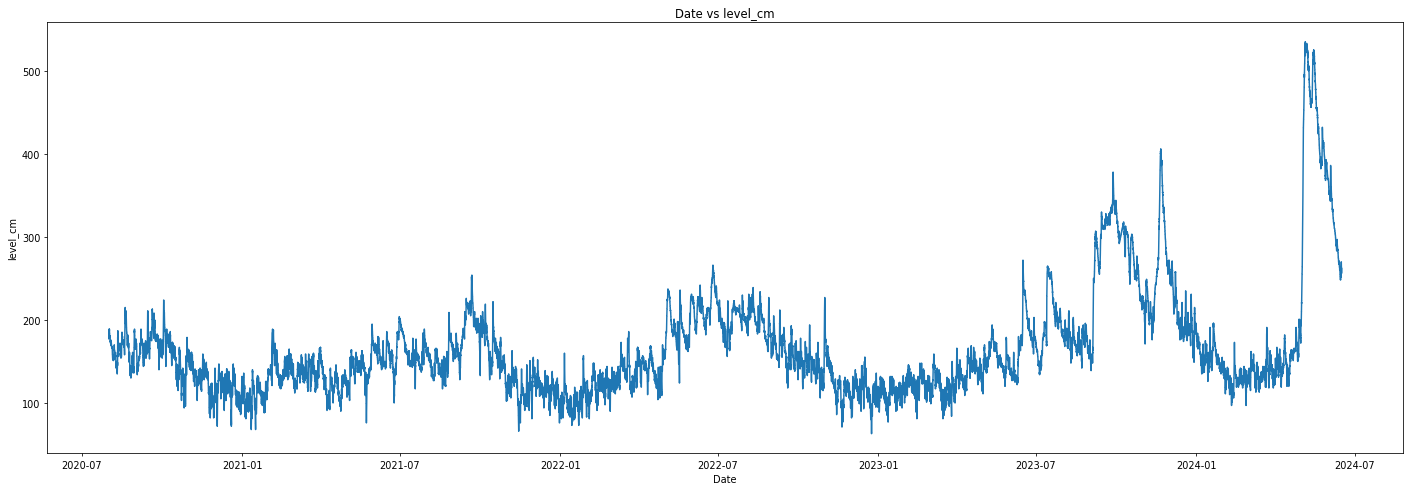

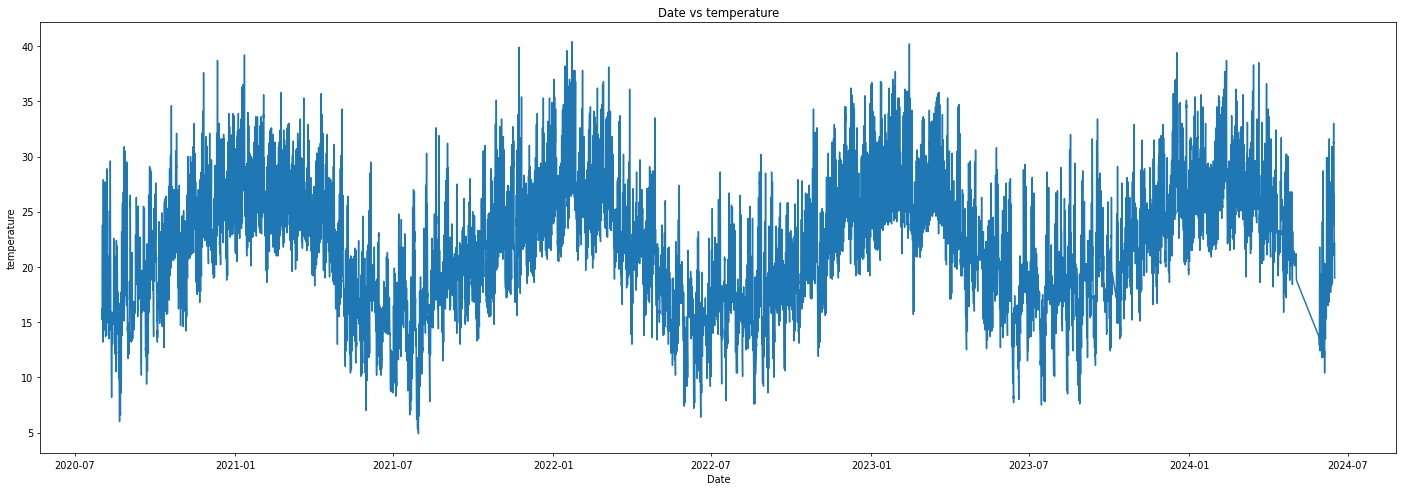

In [14]:
for feature in df_filtered.columns:
    plot_dataset(df_filtered.index, df_filtered[f'{feature}'], 'Date', f'{feature}', f'Date vs {feature}', figsize=(25, 8), dpi=70)

## Making the series stationary

In [15]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")

Dickey–Fuller test

In [16]:
def check_stationarity(df):
  result = adfuller(df)

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
print('\n\n')

In [18]:
df_filtered.columns

Index(['mm/h', 'level_cm', 'temperature'], dtype='object')

### Checking for stationarity

In [ ]:
print("Level_cm")
check_stationarity(df_filtered['level_cm'])
print("\n\ntemperature")
check_stationarity(df_filtered['temperature'])
print("\n\nmm/h")
check_stationarity(df_filtered['mm/h'])

In [19]:
grangercausalitytests(df_filtered[['level_cm', 'temperature']], 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1931.9894, p=0.0000  , df_denom=135837, df_num=1
ssr based chi2 test:   chi2=1932.0321, p=0.0000  , df=1
likelihood ratio test: chi2=1918.4215, p=0.0000  , df=1
parameter F test:         F=1931.9894, p=0.0000  , df_denom=135837, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=792.2488, p=0.0000  , df_denom=135834, df_num=2
ssr based chi2 test:   chi2=1584.5559, p=0.0000  , df=2
likelihood ratio test: chi2=1575.3853, p=0.0000  , df=2
parameter F test:         F=792.2488, p=0.0000  , df_denom=135834, df_num=2


{1: ({'ssr_ftest': (1931.9894493301767, 0.0, 135837.0, 1),
   'ssr_chi2test': (1932.032117884017, 0.0, 1),
   'lrtest': (1918.4215176948928, 0.0, 1),
   'params_ftest': (1931.989449330925, 0.0, 135837.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (792.2488000402127, 0.0, 135834.0, 2),
   'ssr_chi2test': (1584.5559248592024, 0.0, 2),
   'lrtest': (1575.3852853205753, 0.0, 2),
   'params_ftest': (792.2488000400874, 0.0, 135834.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [20]:
grangercausalitytests(df_filtered[['temperature', 'level_cm']], 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=183.2052, p=0.0000  , df_denom=135837, df_num=1
ssr based chi2 test:   chi2=183.2092, p=0.0000  , df=1
likelihood ratio test: chi2=183.0858, p=0.0000  , df=1
parameter F test:         F=183.2052, p=0.0000  , df_denom=135837, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=94.6287 , p=0.0000  , df_denom=135834, df_num=2
ssr based chi2 test:   chi2=189.2644, p=0.0000  , df=2
likelihood ratio test: chi2=189.1326, p=0.0000  , df=2
parameter F test:         F=94.6287 , p=0.0000  , df_denom=135834, df_num=2


{1: ({'ssr_ftest': (183.20519244255038, 1.029735027680825e-41, 135837.0, 1),
   'ssr_chi2test': (183.2092385829785, 9.654876568738169e-42, 1),
   'lrtest': (183.08580117404927, 1.0272960423536018e-41, 1),
   'params_ftest': (183.205192442785, 1.0297350275631139e-41, 135837.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (94.6286943460321, 8.548376884723967e-42, 135834.0, 2),
   'ssr_chi2test': (189.26435518751794, 7.975675218560108e-42, 2),
   'lrtest': (189.13262660460896, 8.518673220705154e-42, 2),
   'params_ftest': (94.62869434456502, 8.548376897311455e-42, 135834.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [53]:
grangercausalitytests(df_filtered[['mm/h', 'level_cm']], 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=113.1835, p=0.0000  , df_denom=135837, df_num=1
ssr based chi2 test:   chi2=113.1860, p=0.0000  , df=1
likelihood ratio test: chi2=113.1388, p=0.0000  , df=1
parameter F test:         F=113.1835, p=0.0000  , df_denom=135837, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=49.8581 , p=0.0000  , df_denom=135834, df_num=2
ssr based chi2 test:   chi2=99.7198 , p=0.0000  , df=2
likelihood ratio test: chi2=99.6832 , p=0.0000  , df=2
parameter F test:         F=49.8581 , p=0.0000  , df_denom=135834, df_num=2


{1: ({'ssr_ftest': (113.18346213275538, 2.0147910592673638e-26, 135837.0, 1),
   'ssr_chi2test': (113.18596182272495, 1.964575514753176e-26, 1),
   'lrtest': (113.13883303164039, 2.0118310996451724e-26, 1),
   'params_ftest': (113.1834621329667, 2.0147910590493747e-26, 135837.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (49.85807909174607, 2.263889807519309e-22, 135834.0, 2),
   'ssr_chi2test': (99.7198286989074, 2.2187804462818164e-22, 2),
   'lrtest': (99.68324428773485, 2.2597403154219243e-22, 2),
   'params_ftest': (49.858079092994785,
    2.2638898046810313e-22,
    135834.0,
    2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [23]:
grangercausalitytests(df_filtered[['mm/h', 'temperature']], 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9604  , p=0.0146  , df_denom=135837, df_num=1
ssr based chi2 test:   chi2=5.9605  , p=0.0146  , df=1
likelihood ratio test: chi2=5.9604  , p=0.0146  , df=1
parameter F test:         F=5.9604  , p=0.0146  , df_denom=135837, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6808  , p=0.0034  , df_denom=135834, df_num=2
ssr based chi2 test:   chi2=11.3620 , p=0.0034  , df=2
likelihood ratio test: chi2=11.3615 , p=0.0034  , df=2
parameter F test:         F=5.6808  , p=0.0034  , df_denom=135834, df_num=2


{1: ({'ssr_ftest': (5.9603642866566, 0.014632285054201466, 135837.0, 1),
   'ssr_chi2test': (5.960495923050661, 0.014629925473814186, 1),
   'lrtest': (5.960365157312481, 0.014631010584832495, 1),
   'params_ftest': (5.9603642867916555, 0.01463228505298246, 135837.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.680783299814749, 0.0034116960564060436, 135834.0, 2),
   'ssr_chi2test': (11.361984814752354, 0.003410172483221013, 2),
   'lrtest': (11.361509668378858, 0.0034109827450096403, 2),
   'params_ftest': (5.680783301096721, 0.0034116960520519475, 135834.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

### Transforming data

In [44]:
df_lag = pd.DataFrame()

df_lag['mm/h_lag_1']        = df_filtered['mm/h'] - df_filtered['mm/h'].shift(1)
df_lag['level_cm_lag_1']    = df_filtered['level_cm'] - df_filtered['level_cm'].shift(1)
df_lag['temperature_lag_1'] = df_filtered['temperature'] - df_filtered['temperature'].shift(1)

df_lag.dropna(inplace=True)
df_lag

,mm/h_lag_1,level_cm_lag_1,temperature_lag_1
date_time,,,
2020-08-01 00:15:00,0.0,0.0,0.0
2020-08-01 00:30:00,0.0,0.0,0.7
2020-08-01 00:45:00,0.0,0.0,0.0
2020-08-01 01:00:00,0.2,0.0,0.0
2020-08-01 01:15:00,-0.2,0.0,0.0
...,...,...,...
2024-06-15 23:00:00,0.0,1.0,0.0
2024-06-15 23:15:00,0.0,1.0,0.0
2024-06-15 23:30:00,0.2,0.0,0.0


In [45]:
lag_features = ['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

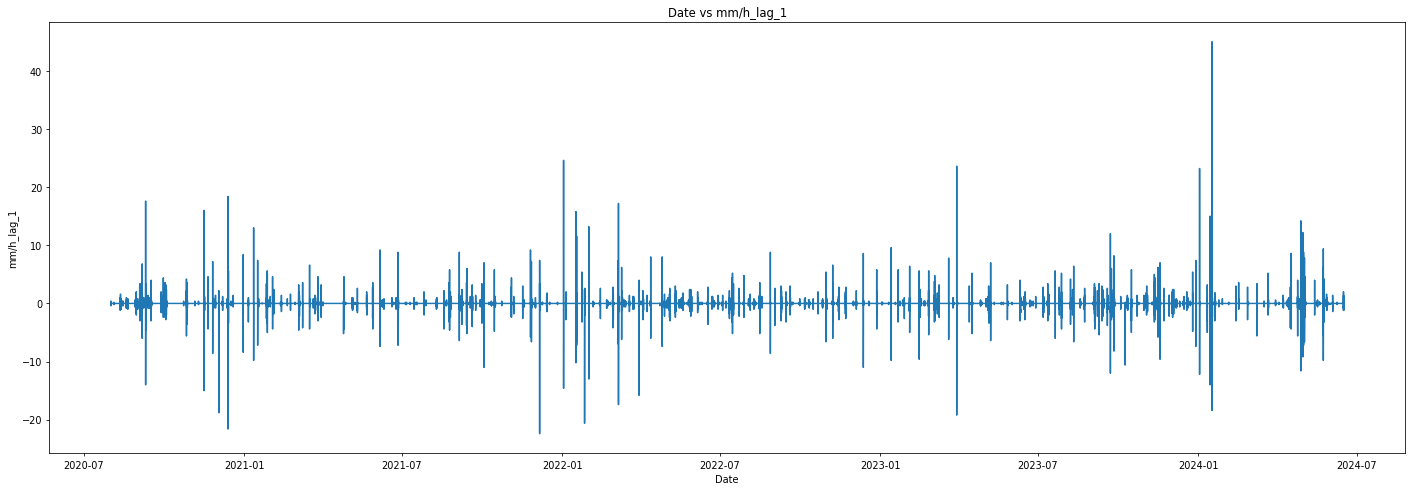

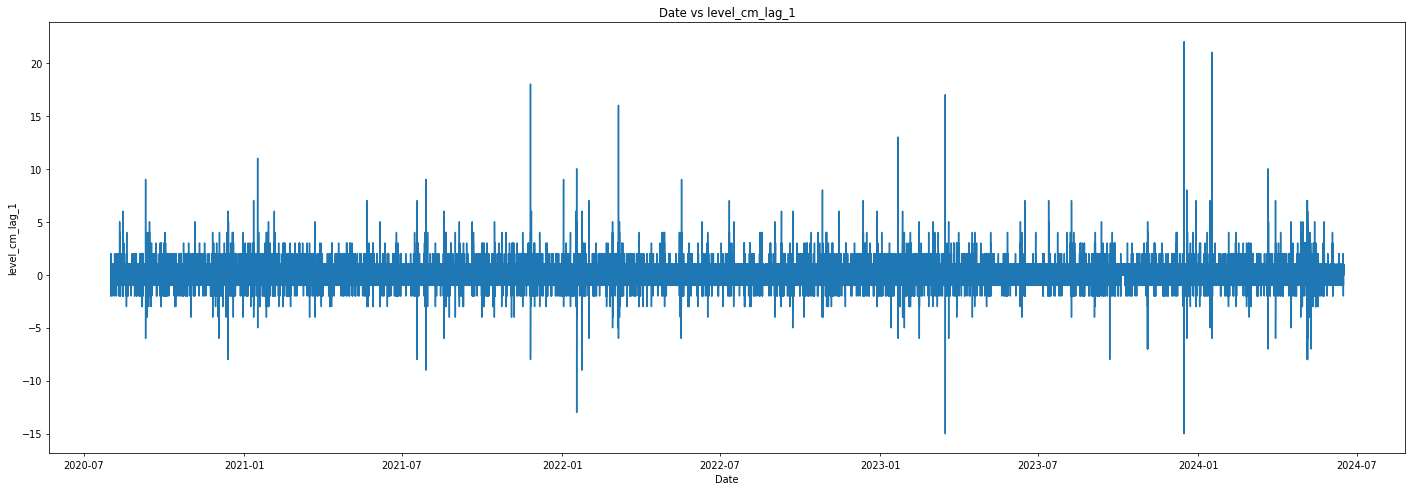

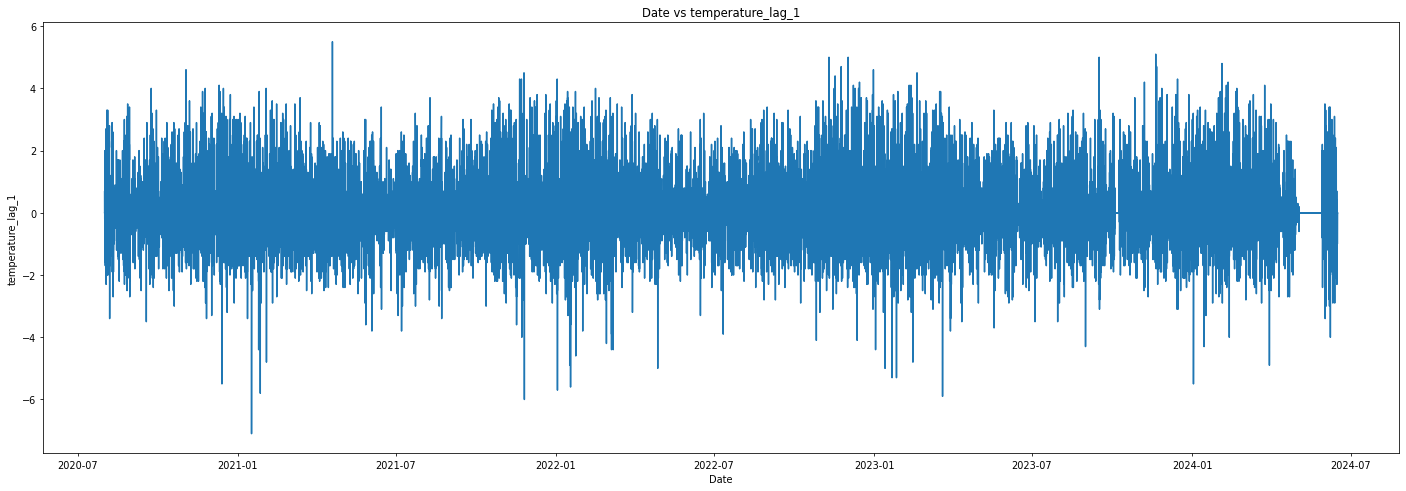

In [46]:
for feature in lag_features:
    plot_dataset(df_filtered.index, df_filtered[f'{feature}'], 'Date', f'{feature}', f'Date vs {feature}', figsize=(25, 8), dpi=70)

#### Checking transformed data

In [31]:
print("Level_cm")
check_stationarity(df_filtered['level_cm_lag_1'])
print("\n\ntemperature")
check_stationarity(df_filtered['temperature_lag_1'])
print("\n\nmm/h")
check_stationarity(df_filtered['mm/h_lag_1'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -45.625778
p-value: 0.000000
Critical values: 
	1%: -3.430398
	5%: -2.861561
	10%: -2.566781


temperature
-- Dickey–Fuller test --
ADF Statistic: -92.027504
p-value: 0.000000
Critical values: 
	1%: -3.430398
	5%: -2.861561
	10%: -2.566781


mm/h
-- Dickey–Fuller test --
ADF Statistic: -62.640722
p-value: 0.000000
Critical values: 
	1%: -3.430398
	5%: -2.861561
	10%: -2.566781


**Using ACF and PACF level_cm**

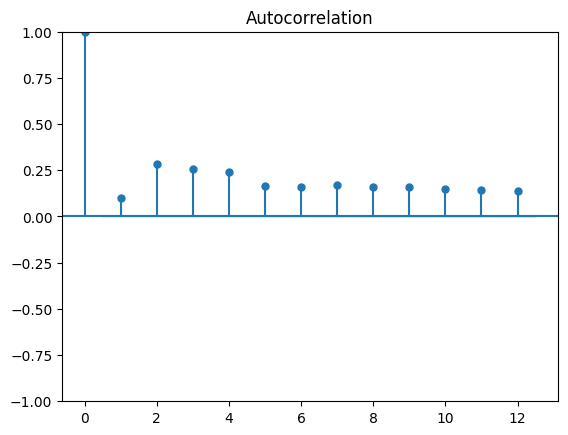

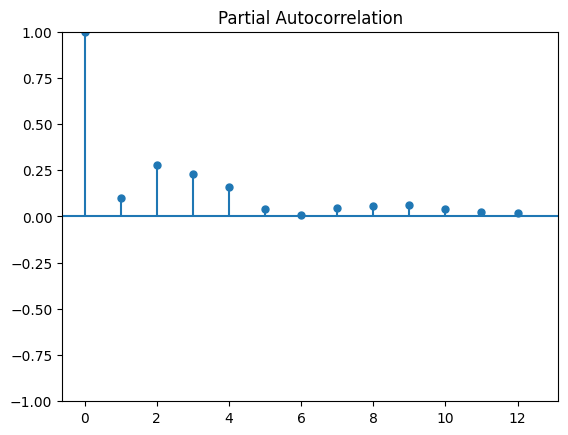

In [57]:
plot_acf(df_lag['level_cm_lag_1'], lags=12)
plot_pacf(df_lag['level_cm_lag_1'], lags=12, method="ols")
plt.show()

**Using ACF and PACF temperatute**

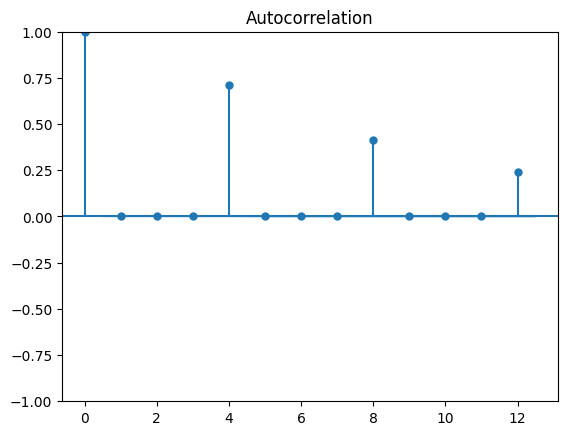

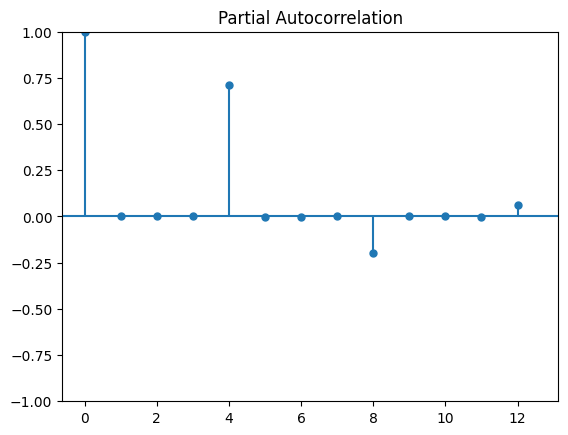

In [58]:
plot_acf(df_lag['temperature_lag_1'], lags=12)
plot_pacf(df_lag['temperature_lag_1'], lags=12, method="ols")
plt.show()

**Using ACF and PACF mm/h**

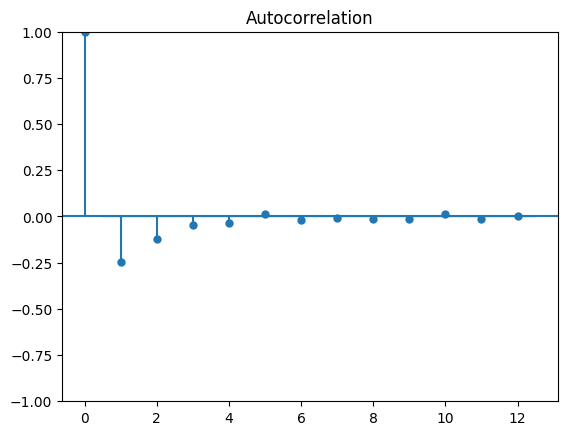

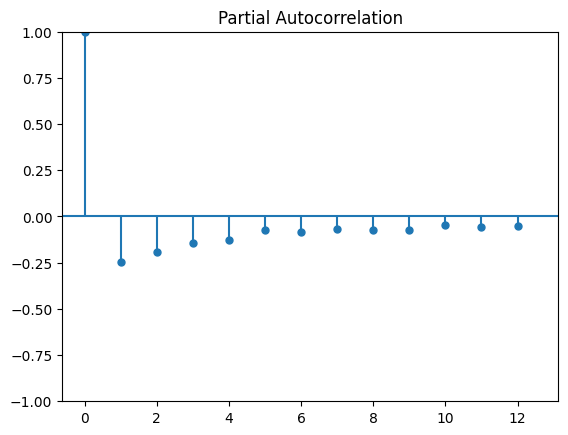

In [59]:
plot_acf(df_lag['mm/h_lag_1'], lags=12)
plot_pacf(df_lag['mm/h_lag_1'], lags=12, method="ols")
plt.show()

## Time Series Decomposition

### Level_cm

In [ ]:
['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

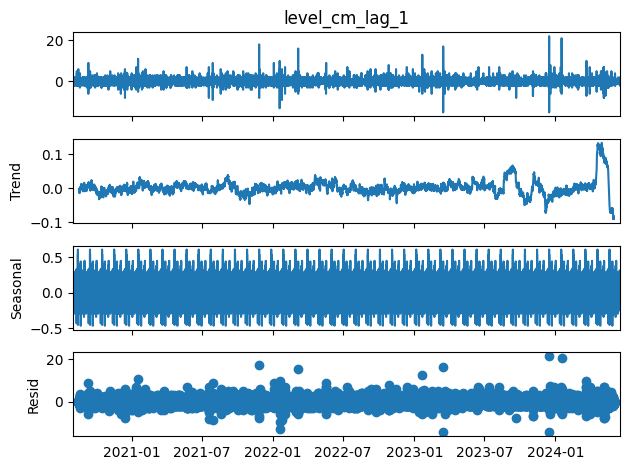

In [50]:
result = seasonal_decompose(df_lag['level_cm_lag_1'], model='additive', period=96)
result.plot()
plt.show()

<Axes: xlabel='date_time'>

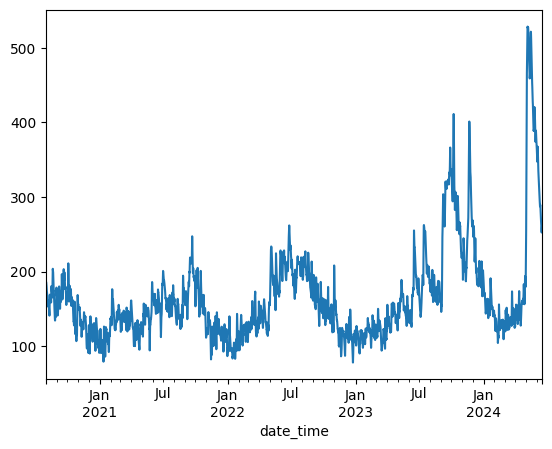

In [ ]:
result.trend.plot()

<Axes: xlabel='date_time'>

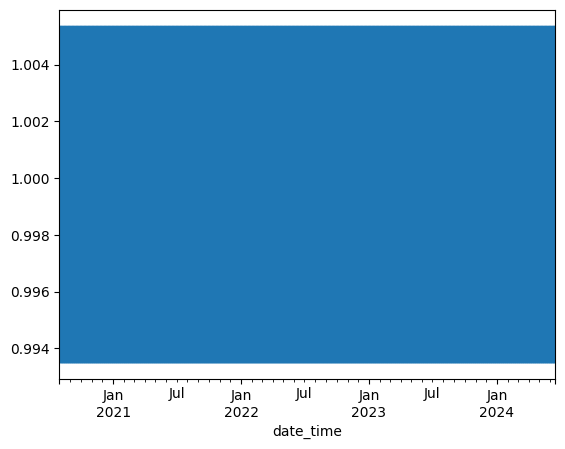

In [24]:
result.seasonal.plot()

<Axes: xlabel='date_time'>

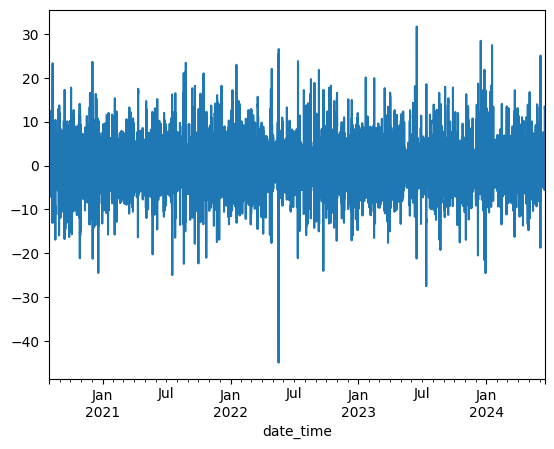

In [ ]:
residual = result.resid
residual.plot()

### Temperature

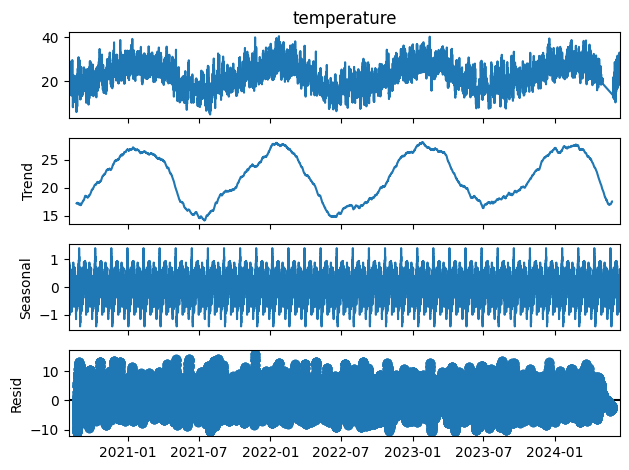

In [26]:
result = seasonal_decompose(df_filtered['temperature'], model='additive', period=3966)
result.plot()
plt.show()

<Axes: xlabel='date_time'>

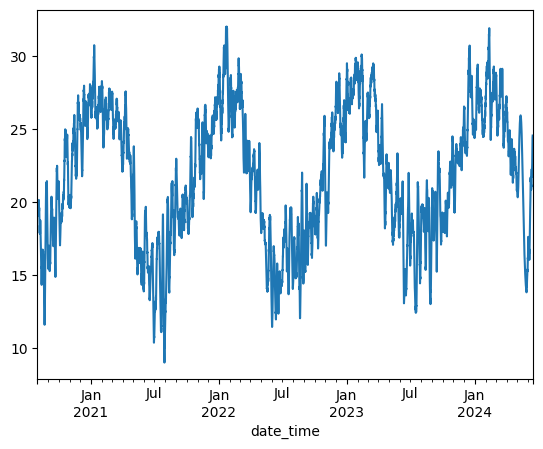

In [ ]:
result.trend.plot()

<Axes: xlabel='date_time'>

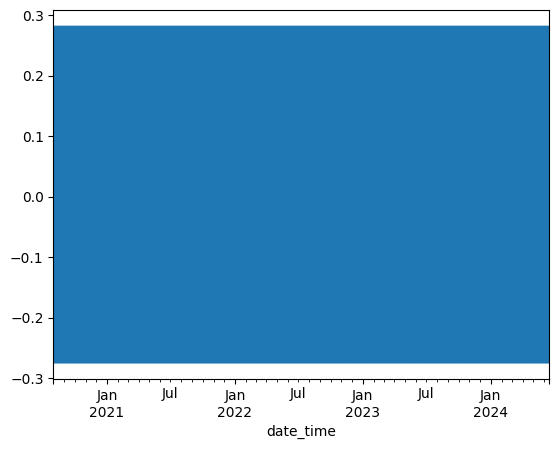

In [ ]:
result.seasonal.plot()

<Axes: xlabel='date_time'>

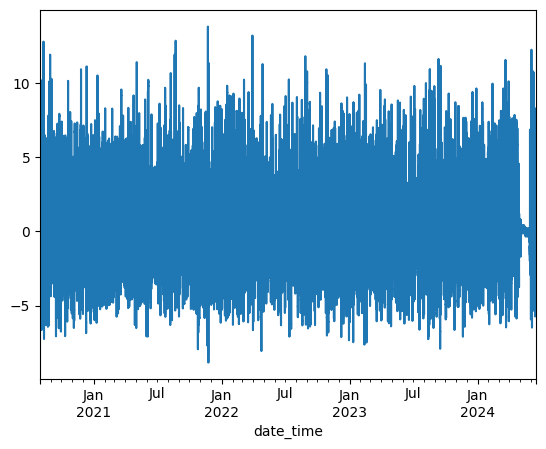

In [ ]:
result.resid.plot()

## Correlation

In [51]:
correlation_matrix = df_lag.corr()
correlation_matrix

,mm/h_lag_1,level_cm_lag_1,temperature_lag_1
mm/h_lag_1,1.000000,0.084847,-0.006268
level_cm_lag_1,0.084847,1.000000,-0.000751
temperature_lag_1,-0.006268,-0.000751,1.000000


<Axes: >

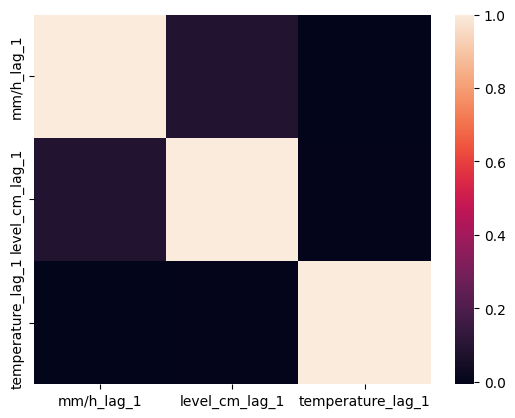

In [52]:
sns.heatmap(correlation_matrix)